# Import and prepare data
Import libraries

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import datetime as dt
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold

%matplotlib inline

Input dataset

In [87]:
pkf = open('dataset/Power.pkl','rb')
power,totalPower = pickle.load(pkf)
power['Heater'] = totalPower['HPE']
power['No heater'] = power['Power'] - power['Heater']
pkf.close()

In [88]:
pkf = open('dataset/nature.pkl','rb')
nature = pickle.load(pkf)
pkf.close()

In [89]:
powerhourly = power.groupby(pd.TimeGrouper(freq='1H')).mean()
alldata = nature.join(powerhourly, how='inner')

Drop null values

In [90]:
alldata = alldata.dropna()

In [91]:
alldata.isnull().sum()

temperature    0
visibility     0
press          0
weather        0
Power          0
Heater         0
No heater      0
dtype: int64

Classify weathers (1-38)

In [92]:
weather = alldata.weather.unique()
a = np.arange(1,39)
for i in range(len(weather)):
    alldata['weather'].iloc[np.where(np.array(alldata.weather)==weather[i])] = a[i]

dates = np.array([x.date() for x in alldata.index])
hours = np.array([x.hour for x in alldata.index])
weekdays = np.array([x.weekday() for x in alldata.index])
months = np.array([x.month for x in alldata.index])
alldata['Hour'] = hours
alldata['Day'] = dates
alldata['Weekday'] = weekdays
alldata['Month'] = months
alldataOneYear = alldata.iloc[:np.where(alldata.index.date==dt.date(2013, 4, 1))[0][0]]
# alldataOneYear

C:\Users\jingx\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Describe dataset
Plot consumption for one year to see the tendency

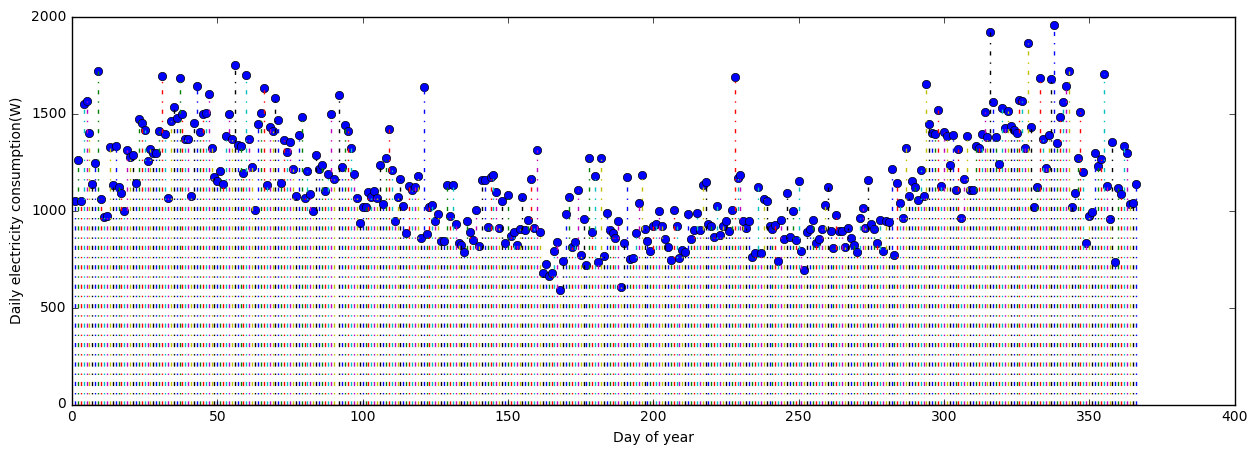

In [93]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['Power'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption(W)')
plt.show()

Plot the temperature for one year to see its tendency

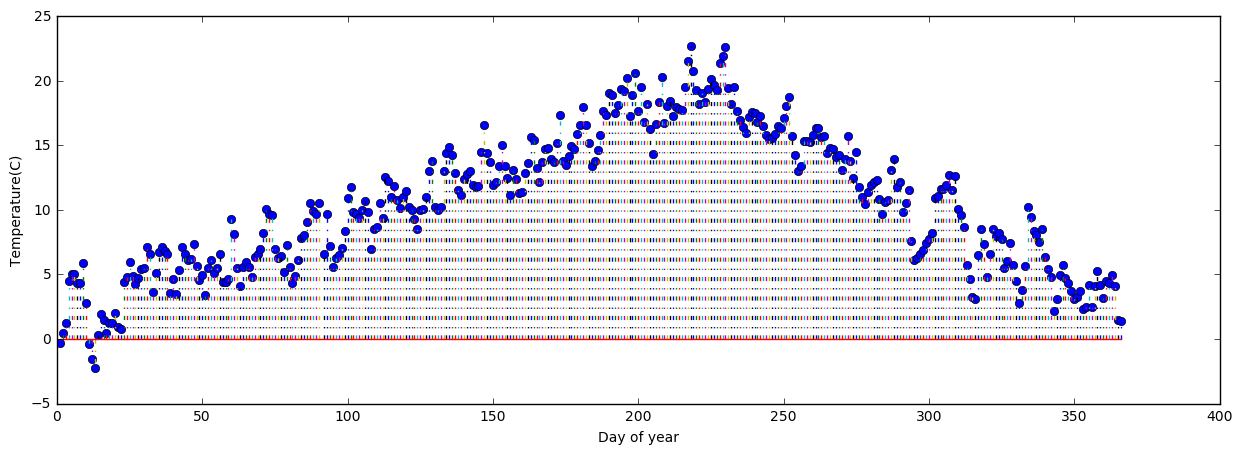

In [94]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['temperature'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Temperature(C)')
plt.show()

The first histogram shows the average hourly consumption on the entire dataset.
7 subplots with similar histograms showing the average hourly consumption for each day of the week.

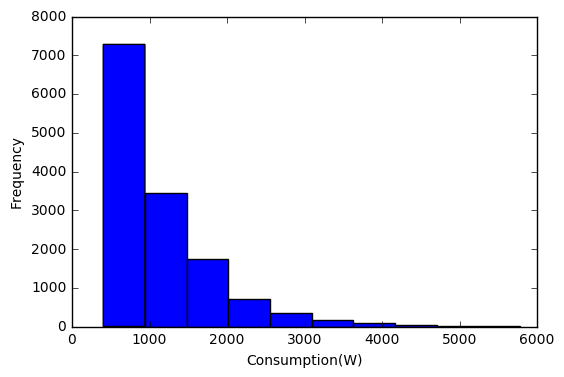

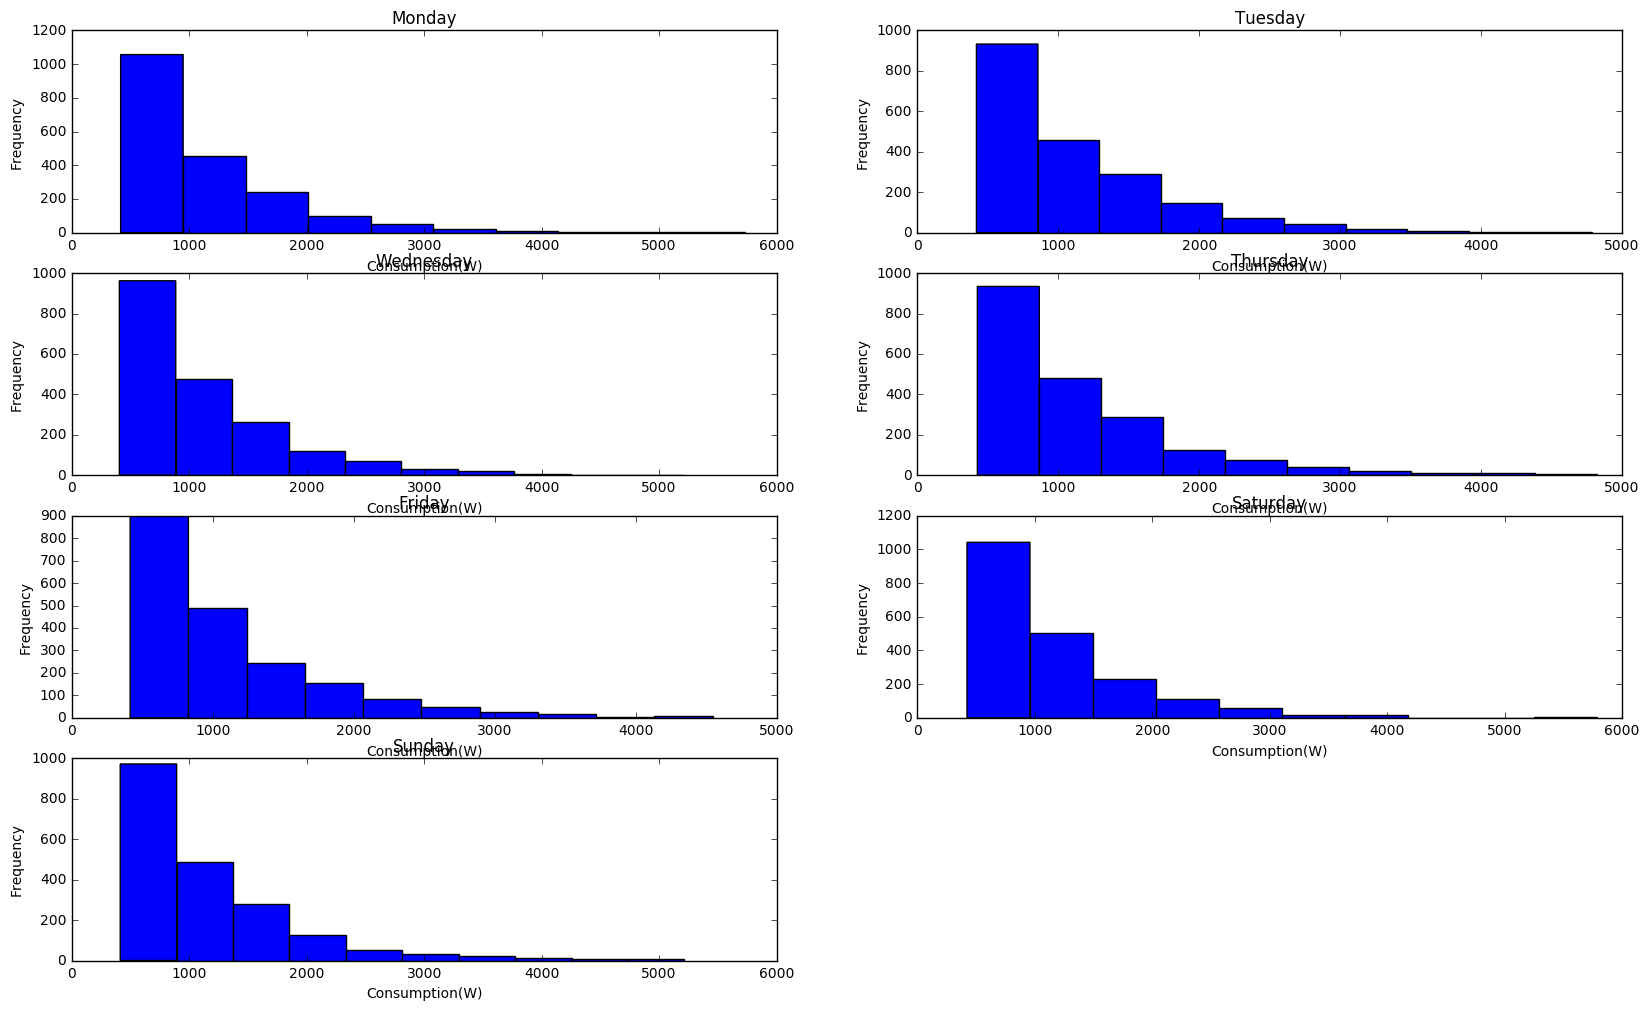

In [95]:
fig1 = plt.figure()
plt.hist(alldata.Power)
plt.xlabel('Consumption(W)')
plt.ylabel('Frequency')

Monday = alldata.ix[alldata.Weekday == 0]
Thusday = alldata.ix[alldata.Weekday == 1] 
Wensday = alldata.ix[alldata.Weekday == 2]
Thursday = alldata.ix[alldata.Weekday == 3]
Friday = alldata.ix[alldata.Weekday == 4]
Saturday = alldata.ix[alldata.Weekday == 5]
Sunday = alldata.ix[alldata.Weekday == 6]

All = [Monday, Thusday, Wensday, Thursday, Friday, Saturday, Sunday]

fig = plt.figure(figsize=(20,12))
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    All[i].index = np.arange(len(All[i]))
    plt.subplot(4,2,i+1)
    plt.hist(All[i].Power)
    plt.title(Days[i])
    plt.xlabel('Consumption(W)')
    plt.ylabel('Frequency')
    plt.show

The first plot shows box plot of the average hourly electricity consumption for each hour of the day.
7 subplots showing the box plots for each of the seven days of the week.

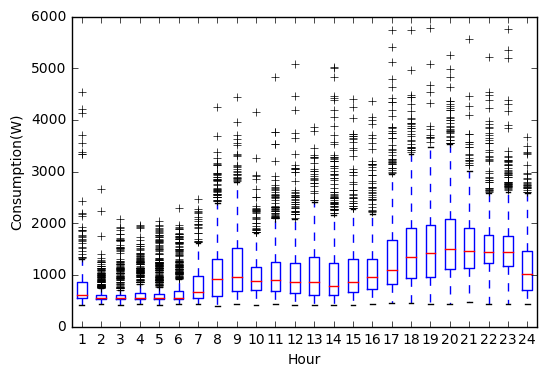

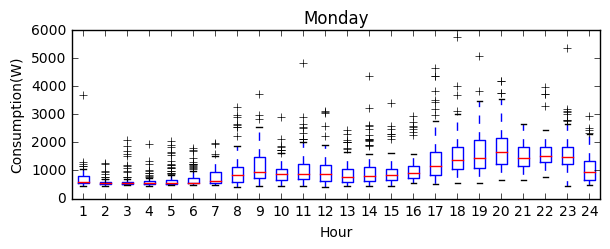

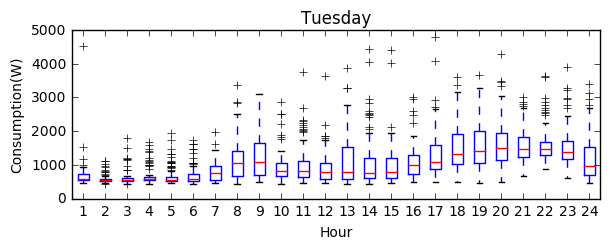

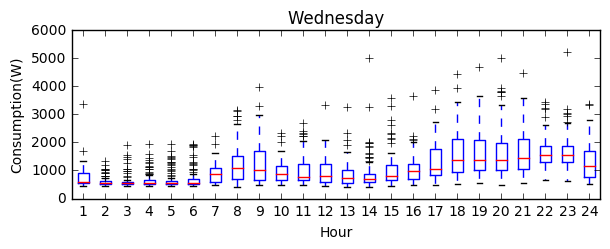

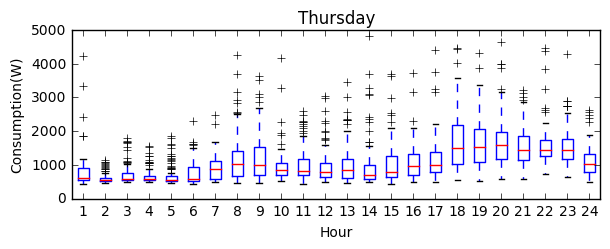

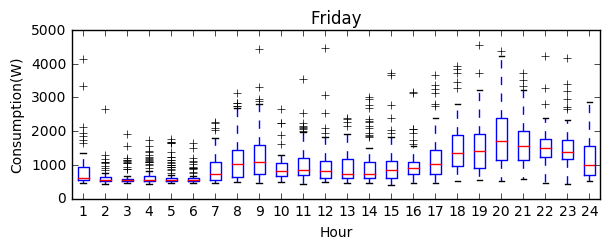

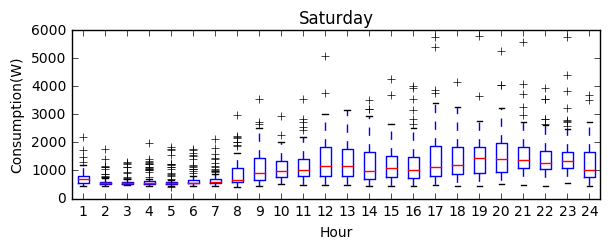

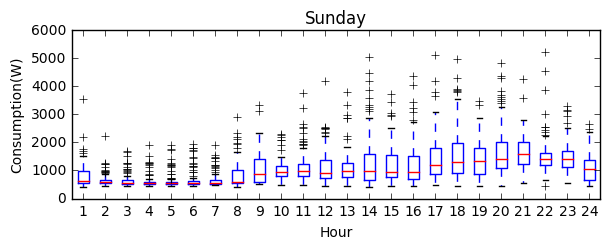

In [96]:
bp = []
for i in range(24):
    bp.append(np.array(alldata.groupby(['Hour','Day']).Power.mean().unstack(level=0)[i].dropna()))
plt.boxplot(bp)
plt.xlabel('Hour')
plt.ylabel('Consumption(W)')
plt.show()
    
bp = []
for i in range(7):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(4,2,i+1)
    for j in range(24):
        bp.append(np.array(All[i].groupby(['Hour','Day']).Power.mean().unstack(level=0)[j].dropna()))
    plt.boxplot(bp)
    bp = []
    plt.title(Days[i])
    plt.xlabel('Hour')
    plt.ylabel('Consumption(W)')
    plt.show()

Heatmap of the daily load curves showing the hours of the day (24 in total), and the vertical axis showing the day of the year (365 total).

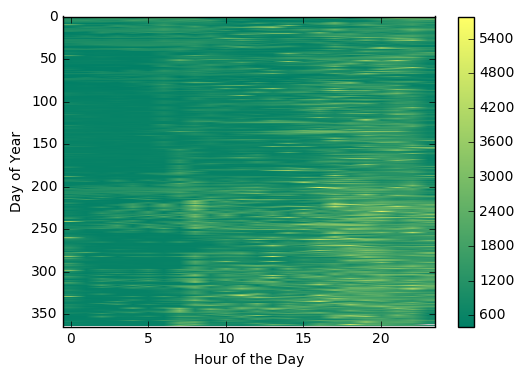

In [97]:
tmp = alldataOneYear[['Power','Hour','Day']].groupby(['Day','Hour'])['Power'].mean()
loadCurves = tmp.unstack(level=1)
# loadCurves.head()

normloadCurves = (loadCurves-loadCurves.min().min())/(loadCurves.max().max()-loadCurves.min().min())
fig = plt.figure(1)
plt.imshow(loadCurves, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()
plt.show()


# Cluster Analysis
perform k-means on the dataset with  k = 2  and the dataset being 365 samples of 24-dimensional vectors.

(365, 24)


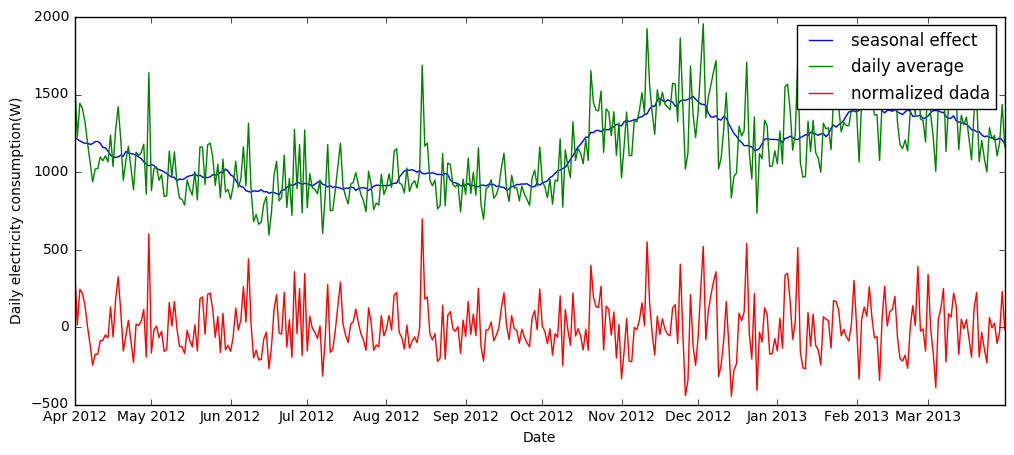

In [98]:
from sklearn.cluster import KMeans

loadCurves = loadCurves.replace(np.inf,np.nan).fillna(0)
Cx = loadCurves.as_matrix().astype(np.float32)
print(Cx.shape)

lp = 10
seasonal = []
for i in range(int(len(Cx))):
    seasonal.append(np.mean(Cx[np.max([i-lp,0]):i+lp,:]))
    
fig = plt.figure(1,figsize=(12,5))
plt.plot(loadCurves.index, seasonal, label='seasonal effect')
plt.plot(loadCurves.index, np.mean(Cx,axis=1), label='daily average')

normX = (Cx.T - seasonal).T
plt.plot(loadCurves.index, np.mean(normX,axis=1), label='normalized dada')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily electricity consumption(W)')

clusters = KMeans(n_clusters=2).fit(normX)

233
132


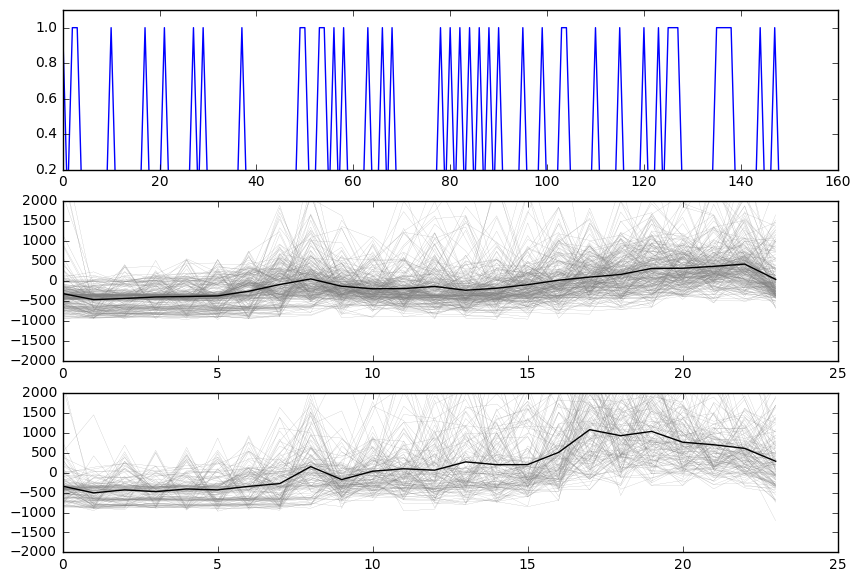

In [99]:
num_clust = 2

fig = plt.figure(1,figsize=(10,7))
cluster_assignments = clusters.predict(normX)
plt.subplot(num_clust+1,1,1)
plt.plot(cluster_assignments[:150])
plt.ylim([0.2,1.1])
for cluster_id in range(len(clusters.cluster_centers_)):
    plt.subplot(num_clust+1,1,cluster_id+2)
    cluster_members = normX[cluster_assignments==cluster_id,:]
    print(len(cluster_members))
    for i in range(len(cluster_members)):
        plt.plot(cluster_members[i,:], color='grey', lw='0.1')
    plt.plot(clusters.cluster_centers_[cluster_id,:], color='k', lw='1')
    plt.ylim([-2000,2000])

# Regression Tree
plot the temperature and consumption vs day in a same image

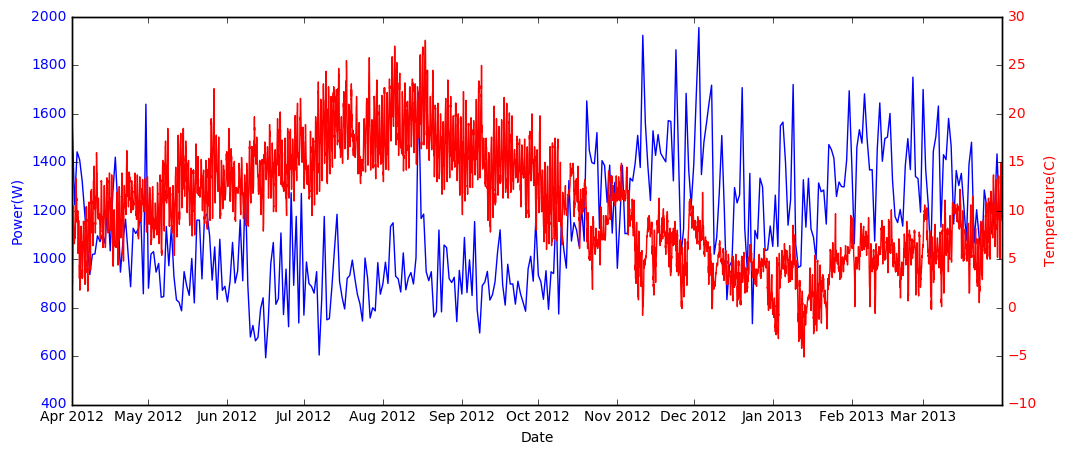

In [100]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(loadCurves.index, np.mean(Cx,axis=1),'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power(W)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(alldataOneYear.index,alldataOneYear['temperature'],'r')
ax2.set_ylabel('Temperature(C)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()


## Training
X is the feature dataframe and Y is the response dataframe. We use X and Y to do the desicion tree regression.

In [101]:
X = alldataOneYear[['temperature','press','visibility','weather','Hour','Weekday']]
Y = alldataOneYear['Power']

In [102]:
from sklearn import linear_model
dtr = DecisionTreeRegressor(max_depth=5)
mld = dtr.fit(X,Y)
print(mld.score(X,Y))


0.339277028264


## Validation
Find the best maximum depth for regreesion tree model.

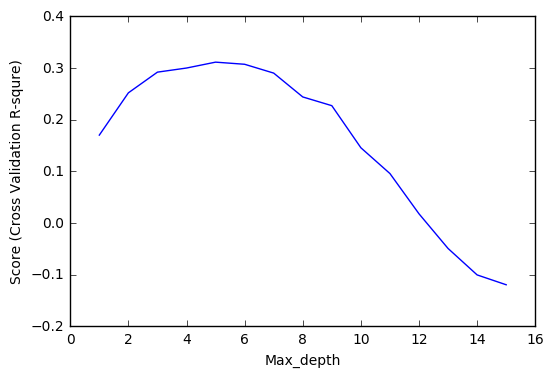

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
score = []
for depth in range(15):
    dtr1 = DecisionTreeRegressor(max_depth=depth+1)
    dtr1 = dtr1.fit(X,Y)
    score.append(cross_val_score(dtr1, X, Y, cv=KFold(n_splits=10, shuffle=True)).mean())
    
plt.plot(np.arange(1,16,1),score)
plt.xlabel('Max_depth')
plt.ylabel('Score (Cross Validation R-squre)')

Rearrange the feature and response dataframe. Put every 12 continous data into a list as one datapoint. 

In [ ]:
powerOneYear = power.iloc[:np.where(power.index.date==dt.date(2013, 4, 1))[0][0]]
groupedPower = powerOneYear['Power'].groupby(pd.TimeGrouper(freq='1H')).aggregate(lambda x: x.tolist())
rX = X
groupedPower = groupedPower[rX.index]

rY = []
n = 0
for i in groupedPower:
    rY.append([])
    if(len(i) == 12):
        for j in i:
            rY[n].append(j)
    n+=1

clf1 = DecisionTreeRegressor(max_depth=5)
clf1 = clf1.fit(rX,rY)
print('Score: ')
print(clf1.score(rX,rY))


Use 10-fold crosss validation to test the rearrange data.

In [ ]:
kfoldY = np.array(Y)
shuffle = KFold(n_splits=10, shuffle=True)
clf2 = DecisionTreeRegressor(max_depth=5)
Score2 = cross_val_score(clf2, X, kfoldY, cv=shuffle)
print('Score: ')
print(Score2.mean())


## TEST

We take second year data to test the model

In [ ]:
alldataSecondYear = alldata.iloc[np.where(alldata.index.date==dt.date(2013, 4, 1))[0][0]:np.where(alldata.index.date==dt.date(2014, 3, 30))[0][0]]

testX = alldataSecondYear[['temperature','press','visibility','weather','Hour','Weekday']]
testY = alldataSecondYear['Power']
print(mld.score(testX,testY))

testPredictY = pd.DataFrame(mld.predict(testX),index=testX.index,columns=['Power'])
testPredictY = testPredictY.groupby(pd.TimeGrouper(freq='1D')).mean()
testY = testY.groupby(pd.TimeGrouper(freq='1D')).mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(testPredictY.index, testPredictY,'r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tested Power(W)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax1.twinx()
ax2.plot(testY.index, testY,'b')
ax2.set_ylabel('Original Power(W)', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')


## PREDICT

We let every temperature increase by 3 to be the new response and the feature dataframe remain the same.

In [ ]:
sumConsumption = Y.groupby(pd.TimeGrouper(freq='1M')).sum()
print(sumConsumption)
print(np.sum(sumConsumption))

predictX = X
predictX['temperature']=X['temperature']+3
predictY = pd.DataFrame(mld.predict(predictX),index=predictX.index,columns=['Power'])
preSumCon = predictY.groupby(pd.TimeGrouper(freq='1M')).sum()
print(preSumCon['Power'])
print(np.sum(preSumCon['Power']))
print('Ratio: ')
print(preSumCon['Power']/sumConsumption)
print(np.sum(preSumCon['Power'])/np.sum(sumConsumption))

predictY = predictY.groupby(pd.TimeGrouper(freq='1D')).mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(predictY.index, predictY,'r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Power(W)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax1.twinx()
ax2.plot(loadCurves.index, np.mean(Cx,axis=1),'b')
ax2.set_ylabel('Original Power(W)', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')


# Removing Heater Consumption
Modify the original data with removing heater consumption. 

Stem plot of consumpton of data without heater in the first year

In [ ]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['No heater'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption (without heater)(W)')
plt.show()

Heat map of the consumption without heater

In [ ]:
tmp = alldataOneYear[['No heater','Hour','Day']].groupby(['Day','Hour'])['No heater'].mean()
lCNoHeater = tmp.unstack(level=1)

normlCNoHeater = (lCNoHeater-lCNoHeater.min().min())/(lCNoHeater.max().max()-lCNoHeater.min().min())
fig = plt.figure(1)
plt.imshow(lCNoHeater, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()
plt.show()


Window average of the consumption without heater

In [ ]:
lCNoHeater = lCNoHeater.replace(np.inf,np.nan).fillna(0)

Cx = lCNoHeater.as_matrix().astype(np.float32)
print(Cx.shape)

lp = 10
seasonal = []
for i in range(int(len(Cx))):
    seasonal.append(np.mean(Cx[np.max([i-lp,0]):i+lp,:]))
    
fig = plt.figure(1,figsize=(12,5))
plt.plot(lCNoHeater.index, seasonal, label='seasonal effect')
plt.plot(lCNoHeater.index, np.mean(Cx,axis=1), label='daily average')
plt.xlabel('Date')
plt.ylabel('Daily electricity consumption (Without heater)(W)')

clusters = KMeans(n_clusters=2).fit(normX)

2-means Cluster of consumption without heater

In [ ]:
num_clust = 2

fig = plt.figure(1,figsize=(10,7))
cluster_assignments = clusters.predict(normX)
plt.subplot(num_clust+1,1,1)
plt.plot(cluster_assignments[:150])
plt.ylim([0.2,1.1])
for cluster_id in range(len(clusters.cluster_centers_)):
    plt.subplot(num_clust+1,1,cluster_id+2)
    cluster_members = normX[cluster_assignments==cluster_id,:]
    print(len(cluster_members))
    for i in range(len(cluster_members)):
        plt.plot(cluster_members[i,:], color='grey', lw='0.1')
    plt.plot(clusters.cluster_centers_[cluster_id,:], color='k', lw='1')
    plt.ylim([-2000,2000])

Stem plot of heater consumption in the first year

In [ ]:
fig = plt.figure(figsize=(15,5))
heaterDaily = alldataOneYear['Heater'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(heaterDaily.index, heaterDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption (Only heater)(W)')
plt.show()

Plot heater consumption and temperature in the first year in one graph.

In [ ]:
lCHeater = alldataOneYear[['Heater','Hour','Day']].groupby('Day')['Heater'].mean()

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(lCHeater.index, lCHeater,'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heater Power Consumption(W)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(alldataOneYear.index,alldataOneYear['temperature'],'r')
ax2.set_ylabel('Temperature', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()


The max value every month

In [ ]:
alldataDay = alldata.resample('1d').mean()
alldataDay['month'] = np.array([x.month for x in alldataDay.index])
alldataDay['weekday'] = np.array([x.weekday() + 1 for x in alldataDay.index])
alldataDay[alldataDay.groupby(['month'])['Power'].transform(max) == alldataDay['Power']]